## Dataset 
Dataset DeepScores V2 struttura  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import classification_report
!apt-get install libmagic-dev
!pip install python-magic
import os
from os import remove
import random
from pathlib import Path
from PIL import Image
import pickle

import tensorflow as tf
import numpy as np
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization
from matplotlib import pyplot as plt

try: 
  import augly.image as imaugs
except ModuleNotFoundError:
  !pip install augly
  import augly.image as imaugs



COLAB_ROOT = '/content/drive/MyDrive/progetti_uniba/cv_notes/oemer-main/oemer' #'/content/drive/MyDrive/oemer-main/oemer'
PROJECT_ROOT ='/content/drive/MyDrive/progetti_uniba/cv_notes/oemer-main'  #'/content/drive/MyDrive/oemer-main/oemer'
DATASET_PATH = '/content/drive/MyDrive/progetti_uniba/cv_notes/oemer-main/dataset/ds2_dense/segmentation' #'/content/drive/MyDrive/oemer-main/dataset/ds2_dense/segmentation'

import sys 
sys.path.insert(0,COLAB_ROOT)
from bbox import get_bbox, merge_nearby_bbox, draw_bounding_boxes, rm_merge_overlap_bbox


TARGET_WIDTH = 40
TARGET_HEIGHT = 70
DISTANCE = 10




Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1
Suggested packages:
  file
The following NEW packages will be installed:
  libmagic-dev libmagic-mgc libmagic1
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 332 kB of archives.
After this operation, 5,552 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-mgc amd64 1:5.32-2ubuntu0.4 [184 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic1 amd64 1:5.32-2ubuntu0.4 [68.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-dev amd64 1:5.32-2ubuntu0.4 [79.7 kB]
Fetched 332 kB in 1s (525 kB/s)
Selecting previously uns

### **Funzioni per la creazione del dataset e l'individuazione di esempi**

In [ ]:

FILES = os.listdir(DATASET_PATH)

def find_example(color: int,max_count=500,mark_value=200):
    global FILES
    random.shuffle(FILES)
    for ff in FILES :
        path = os.path.join(DATASET_PATH, ff)
        img = Image.open(path)
        arr = np.array(img)
        if color in arr:
          print(f'{path} collect')
          FILES.remove(ff)
          return np.where(arr==color, mark_value, arr)
        FILES.remove(ff)


def collect(color, out_path, samples=100,reset = True):
    global FILES
    if reset:
      FILES =  os.listdir(DATASET_PATH)
    out_path = Path(out_path)
    if not out_path.exists():
        out_path.mkdir()

    cur_samples = 0
    add_space = 10
    idx = 0
    while cur_samples < samples and len(FILES) > 0 :
      
        arr = find_example(color)
        if arr is None:
            continue
        arr[arr!=200] = 0
        boxes = get_bbox(arr)
        if len(boxes) > 1:
            boxes = merge_nearby_bbox(boxes, DISTANCE)
        boxes = rm_merge_overlap_bbox(boxes)
        for box in boxes:
            if idx >= samples:
                break
            print(f"{idx+1}/{samples}", end='\r')
            patch = arr[box[1]-add_space:box[3]+add_space, box[0]-add_space:box[2]+add_space]
            ratio = random.choice(np.arange(0.6, 1.3, 0.1))
            tar_w = int(ratio * patch.shape[1])
            tar_h = int(ratio * patch.shape[0])
            img = imaugs.resize(Image.fromarray(patch.astype(np.uint8)), width=tar_w, height=tar_h)

            seed = random.randint(0, 1000)
            img = imaugs.perspective_transform(img, seed=seed, sigma=3)
            img = np.where(np.array(img)>0, 255, 0)
            Image.fromarray(img.astype(np.uint8)).save(out_path / f"{idx}.png")
            idx += 1

        cur_samples += len(boxes)
    print()


In [29]:


def convert_rgb(X):
  rgb_X = []
  for gray_x in X:
    gray_x = gray_x.reshape((gray_x.shape[0],gray_x.shape[1],1))
    rgb_X += [tf.image.grayscale_to_rgb(tf.constant(gray_x)) ]
  return np.array(rgb_X)
  
def train_tensorflow_model(get_model,folders,k_fold = None,epochs = 10):
    class_map = {idx: Path(ff).name for idx, ff in enumerate(folders)}
    X = []
    y = []
    samples = None
    print("Loading data")
    for cidx, folder in enumerate(folders):
        folder = Path(folder)
        idx = 0
        for ff in folder.iterdir():
            if samples is not None and idx >= samples:
                break
            img = Image.open(ff).resize((TARGET_WIDTH, TARGET_HEIGHT))
            arr = np.array(img)
            X.append(arr)
            y.append(cidx)
            idx += 1



    X = convert_rgb(X)

    y = np.array(y)
    print(f'Train Size : {X.shape}')

    if k_fold == None:

      train_x = np.array(X)#[..., np.newaxis]
      train_y = tf.one_hot(y, len(folders))



      output_types = (tf.uint8, tf.uint8)
      output_shapes = ((TARGET_HEIGHT, TARGET_WIDTH, 3), (len(folders)))
      print(train_x.shape)
    
      training_set = tf.data.Dataset.from_generator(lambda: zip(train_x, train_y), output_types=output_types, output_shapes=output_shapes)


      training_set = training_set.shuffle(len(train_y), reshuffle_each_iteration=True)
      training_set = training_set.repeat(5)
      training_set = training_set.batch(16)
    
     
      model = get_model(folders)

      history  = model.fit(training_set, batch_size = 64, epochs=epochs,verbose = 1)
      
      # convert grayscale to rgb
 

    return model, class_map

In [55]:


def test_tensorflow_model(model, folders):
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import numpy as np

    test_x = []
    test_y = []
    print("Loading data")
    for cidx, folder in enumerate(folders):
        folder = Path(folder)
        files = list(folder.iterdir())
        random.shuffle(files)
        for ff in files:
            img = Image.open(ff).resize((TARGET_WIDTH, TARGET_HEIGHT))
            arr = np.array(img)
            test_x.append(arr)
            test_y.append(cidx)

    test_x = convert_rgb(test_x)
    test_x = np.array(test_x)#[..., np.newaxis]
    test_y = np.array(test_y)

    print(f'Test Size : {test_x.shape}')
    test_result = []
    batch_size = 16
    for idx in range(0, len(test_x), batch_size):
        data = test_x[idx:idx+batch_size]
        pred = model.predict(data)
        pidx = np.argmax(pred, axis=-1)
        test_result.extend(list(pidx))

    test_result = np.array(test_result)

    tp = test_result[test_result==test_y].size
    acc = tp / len(test_y)

    cm = confusion_matrix(test_y, test_result)
    import os 

    display_labels = [os.path.split(f)[1] for f in folders] 

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
    plt.show()

    print(classification_report(test_result, test_y, target_names=display_labels))





In [73]:
"""
def get_model(folders):
  model = tf.keras.models.Sequential([
          tf.keras.layers.InputLayer(input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 1)),

          tf.keras.layers.Conv2D(64, (6, 6), activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.2),

          tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.2),


           tf.keras.layers.Conv2D(16, (2, 2), activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.2),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(len(folders), activation='softmax')
      ])
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model
"""

def get_model(folders):
  #Still not talking about our train/test data or any pre-processing.

  model = tf.keras.models.Sequential()


  #model.add(tf.keras.applications.resnet50.ResNet50(include_top = False, weights = 'imagenet', input_shape=(70,40,3))) 
  #model.add(tf.keras.applications.MobileNet(include_top = False, weights = 'imagenet', input_shape=(70,40,3)))
  #model.add(tf.keras.applications.EfficientNetV2L(include_top = False, weights = 'imagenet', input_shape=(70,40,3))) 
  model.add(tf.keras.applications.VGG16(include_top = False, weights = 'imagenet', input_shape=(70,40,3))) 
  


  # 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
  #model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dense(len(folders), activation = 'softmax'))


  # Say not to train first layer (ResNet) model as it is already trained
  model.layers[0].trainable = False
  model.summary()
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [47]:
GENERATE_DATASET = False

TRAIN_DATAPATH = f"{COLAB_ROOT}/train_data"
TEST_DATAPATH = f"{COLAB_ROOT}/test_data"

samples = 200



"""
color_map = {
  74: "sharp",
  70: "flat",
  72: "natural"
}

color_map = {
     10: 'gclef',
     13: 'fclef'
 }



"""
color_map = {
  97: 'rest_whole',
  98: 'rest_half',
  99: 'rest_quarter',
  100: 'rest_8th',
  101: 'rest_16th',
  102: 'rest_32nd',
  103: 'rest_64th',
  10: 'gclef',
  13: 'fclef',
  74: "sharp",
  70: "flat",
  72: "natural"
}

if not os.path.exists(TRAIN_DATAPATH):
  print(f'create directory {TRAIN_DATAPATH}')
  os.mkdir(TRAIN_DATAPATH)

if not os.path.exists(TEST_DATAPATH):
  os.mkdir(TEST_DATAPATH)
  print(f'create directory {TRAIN_DATAPATH}')

if GENERATE_DATASET:
#genera un dataset di segmenti di immagini dividendoli in cartelle
  for color, name in color_map.items():
      print(f'collect {name} examples')
      collect(color, f"{TRAIN_DATAPATH}/{name}", samples=samples)
      collect(color, f"{TEST_DATAPATH}/{name}", samples=samples,reset = False)




Loading data
Train Size : (2200, 70, 40, 3)
(2200, 70, 40, 3)
58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 1, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 1024)              0         
                                                                 
 dense_23 (Dense)            (None, 512)               524800    
                                                                 
 dense_24 (Dense)            (None, 11)                5643      
                                                                 
Total params: 15,245,131
Trainable params: 530,443
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/6
688/688 [=====================

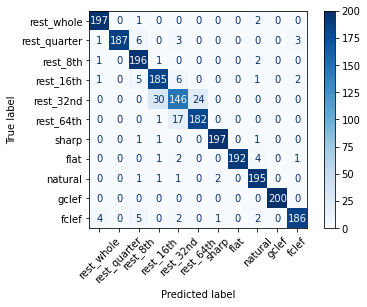

              precision    recall  f1-score   support

  rest_whole       0.98      0.97      0.98       204
rest_quarter       0.94      1.00      0.97       187
    rest_8th       0.98      0.91      0.94       215
   rest_16th       0.93      0.84      0.88       220
   rest_32nd       0.73      0.82      0.77       177
   rest_64th       0.91      0.88      0.90       206
       sharp       0.98      0.98      0.98       200
        flat       0.96      1.00      0.98       192
     natural       0.97      0.94      0.96       207
       gclef       1.00      1.00      1.00       200
       fclef       0.93      0.97      0.95       192

    accuracy                           0.94      2200
   macro avg       0.94      0.94      0.94      2200
weighted avg       0.94      0.94      0.94      2200



In [74]:

# folders = ["gclef", "fclef"]; model_name = "clef"
# folders = ["sharp", "flat", "natural"]; model_name = "sfn"
folders = ["rest_whole", "rest_quarter", "rest_8th", "rest_16th", "rest_32nd", "rest_64th","sharp", "flat", "natural","gclef", "fclef"]; model_name = "VGG16"
# folders = ["rest_8th", "rest_16th", "rest_32nd", "rest_64th"]; model_name = "rests_above8"
# folders = ['clefs', 'sfns']; model_name = 'clefs_sfns'



model, class_map = train_tensorflow_model(get_model,[f"{TRAIN_DATAPATH}/{folder}" for folder in folders],epochs=6) # TF-based model

test_tensorflow_model(model, [f"{TEST_DATAPATH}/{folder}" for folder in folders])

output = {'model': model, 'w': TARGET_WIDTH, 'h': TARGET_HEIGHT, 'class_map': class_map}

if not os.path.exists(f"{COLAB_ROOT}/tf_models/"):
  os.mkdir(f"{COLAB_ROOT}/tf_models/")
  
pickle.dump(output, open(f"{COLAB_ROOT}/tf_models/{model_name}.model", "wb"))

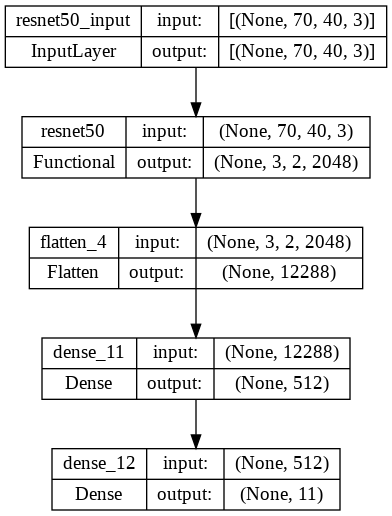

In [45]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)